In [ ]:
%pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.3 MB/s eta 0:00:00


In [ ]:
import sys
import os

def is_colab_env():
    return "google.colab" in sys.modules

def mount_google_drive(drive_dir="/content/drive/", repo_dir="MyDrive/repositories/deepfake-detection"):
    # mount google drive
    from google.colab import drive
    drive.mount(drive_dir)

    # change to correct working directory
    import os
    repo_dir = f"{drive_dir}{repo_dir}"
    os.chdir(repo_dir)
    print(os.listdir()) # verify content
    return repo_dir

def resolve_path(levels_deep=3):
    if is_colab_env():
        return mount_google_drive()
    else:
        # Get the directory of the current script
        current_dir = os.path.dirname(os.path.abspath('__file__'))

        # Construct the path to the parent directory
        for i in range(levels_deep):
            current_dir = os.path.dirname(current_dir)

        # Add the parent directory to sys.path
        sys.path.append(current_dir)
        print(sys.path)
        return current_dir

proj_dir = resolve_path()

Mounted at /content/drive/
['src', '.git', 'playground', 'reports', 'analysis', 'faceforensics_download.py', 'freqnet_image.ipynb', 'hf_wdf.sh', 'run_jupyter.sh', 'setup', 'config.py', 'preprocessing', 'README.md', 'samples', '.gitignore', '__pycache__', 'server.py', 'environment.yml']


In [ ]:
import config
import numpy as np
from PIL import Image
import cv2
from src.model_registry import MODEL_REGISTRRY

face_cascade = cv2.CascadeClassifier(proj_dir + '/preprocessing/haarcascade_frontalface_default.xml')

In [ ]:
# pytorch
import torch
import pytorch_lightning as L

In [ ]:
# import local dependencies
from src.models.resnet import ResNetClassifier
from src.transforms.frequency import get_transforms

In [ ]:
model_id = "dwt_rgb_resnet18"
model_checkpoint_dir = f"{proj_dir}/{config.CHECKPOINTS_DIR}/{model_id}"

In [ ]:
seed = config.SEED

# Set seeds for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# Determine device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
models = {}
transforms = {}

for model_id, spec in MODEL_REGISTRRY.items():
    ckpt_path = f"{proj_dir}/{config.CHECKPOINTS_DIR}/{model_id}/{spec['checkpoint']}"
    model = ResNetClassifier.load_from_checkpoint(
        checkpoint_path=ckpt_path,
        in_channels=spec.get("in_channels", 3),
        freeze_features=False,
        weights_only=False,
    )
    model.eval()
    models[model_id] = model
    transforms[model_id] = get_transforms(mode=spec["transforms_mode"], image_size=224)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 92.6MB/s]


In [ ]:
def get_cropped_face(img_data, crop_factor=1.1):
    """
    Detects a face in an image and returns the cropped face as a NumPy array.

    :param img_data: The input image as a NumPy array (BGR format).
    :param crop_factor: Factor to extend the bounding box.
    :return: A NumPy array representing the cropped BGR face, or None if no face is found.
    """
    img = img_data
    if img is None or img.size == 0:
        print("Error: Empty image data provided.")
        return None

    # 1. Convert to grayscale for detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Detect faces
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    if len(faces) == 0:
        print("No face detected.")
        return None

    # 3. Crop the largest face (assuming the main subject is the largest face)
    (x, y, w, h) = sorted(faces, key=lambda f: f[2] * f[3], reverse=True)[0]

    # 4. Apply a 'crop factor' for padding
    center_x = x + w // 2
    center_y = y + h // 2
    size = int(max(w, h) * crop_factor)

    # Calculate the coordinates for the padded square crop
    x_start = max(0, center_x - size // 2)
    y_start = max(0, center_y - size // 2)
    x_end = min(img.shape[1], center_x + size // 2)
    y_end = min(img.shape[0], center_y + size // 2)

    # Adjust start/end if clipping occurred to ensure a square crop
    final_size = min(x_end - x_start, y_end - y_start)

    # Final Crop
    cropped_face = img[y_start : y_start + final_size, x_start : x_start + final_size]

    return cropped_face

In [28]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms as T

class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model.eval()
        self.target_layer = None
        self.gradients = None

        # Register hooks
        for name, module in self.model.named_modules():
            if name == target_layer_name:
                module.register_forward_hook(self.save_activation)
                module.register_backward_hook(self.save_gradient)
                self.target_layer = module
                break

        if self.target_layer is None:
            raise ValueError(f"Target layer '{target_layer_name}' not found in model.")

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()

        # Forward pass
        output = self.model(input_tensor)

        if class_idx is None:
            # Get the index of the max logit (predicted class)
            class_idx = output.argmax(dim=1).item()

        # Backward pass for the predicted class
        target_output = output[:, class_idx]
        target_output.backward(retain_graph=True)

        # Get gradients and activations
        gradients = self.gradients.cpu()
        activations = self.activations.cpu()

        # Global average pooling of gradients
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # Weight the channels by corresponding gradients
        for i in range(activations.size(1)):
            activations[:, i, :, :] *= pooled_gradients[i]

        # Average the channels to obtain the heatmap
        heatmap = torch.mean(activations, dim=1).squeeze()

        # ReLU on heatmap
        heatmap = F.relu(heatmap)

        # Normalize the heatmap
        heatmap /= torch.max(heatmap)

        return heatmap

def visualize_cam(original_image_pil, heatmap, ax, title=None, alpha=0.4):
    # Convert original_image_pil to a tensor if needed, then to numpy
    if isinstance(original_image_pil, Image.Image):
        original_image_np = np.array(original_image_pil)
    else:
        original_image_np = original_image_pil # Assume it's already a numpy array (RGB)

    # Resize heatmap to original image size
    h, w = original_image_np.shape[:2]
    heatmap_resized = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0),
                                    size=(h, w), mode='bilinear', align_corners=False)
    heatmap_resized = heatmap_resized.squeeze().detach().numpy() # Added .detach()

    # Normalize heatmap to [0, 1]
    heatmap_resized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) - np.min(heatmap_resized))

    # Apply colormap to heatmap
    cmap = plt.get_cmap('jet')
    heatmap_colored = cmap(heatmap_resized)[:, :, :3] # Remove alpha channel

    # Overlay heatmap on original image
    # Ensure original_image_np is float for blending
    original_image_float = original_image_np.astype(np.float32) / 255.0
    overlay = original_image_float + alpha * heatmap_colored
    overlay = np.clip(overlay, 0, 1)

    ax.imshow(overlay)
    ax.axis('off')
    if title:
        ax.set_title(title)


In [41]:
sample_image_path = f"{proj_dir}/samples/real/real_10.png"
img_id = sample_image_path.split("/")[-1].split(".")[0]
new_image_pil = Image.open(sample_image_path).convert('RGB') # Ensure RGB
new_image_np_rgb = np.array(new_image_pil)
new_image_np_bgr = cv2.cvtColor(new_image_np_rgb, cv2.COLOR_RGB2BGR)

# Detect and Crop Face
cropped_face_np_bgr = get_cropped_face(new_image_np_bgr)

if cropped_face_np_bgr is None:
    # print(f"  [Skipping] No face detected in {os.path.basename(img_path)}, using entire image.")
    cropped_face_np_bgr = new_image_np_bgr

# Convert back to PIL for transforms
cropped_face_pil_rgb = Image.fromarray(cv2.cvtColor(cropped_face_np_bgr, cv2.COLOR_BGR2RGB))


Now, let's select the `dwt_rgb_resnet18` model, apply its specific transforms, and then generate the Grad-CAM visualization for the `cropped_face_pil_rgb` image. The target layer for Grad-CAM is typically the last convolutional layer before the global average pooling.

Image saved as '/content/drive/MyDrive/repositories/deepfake-detection/analysis/gradcam/real_10.png'


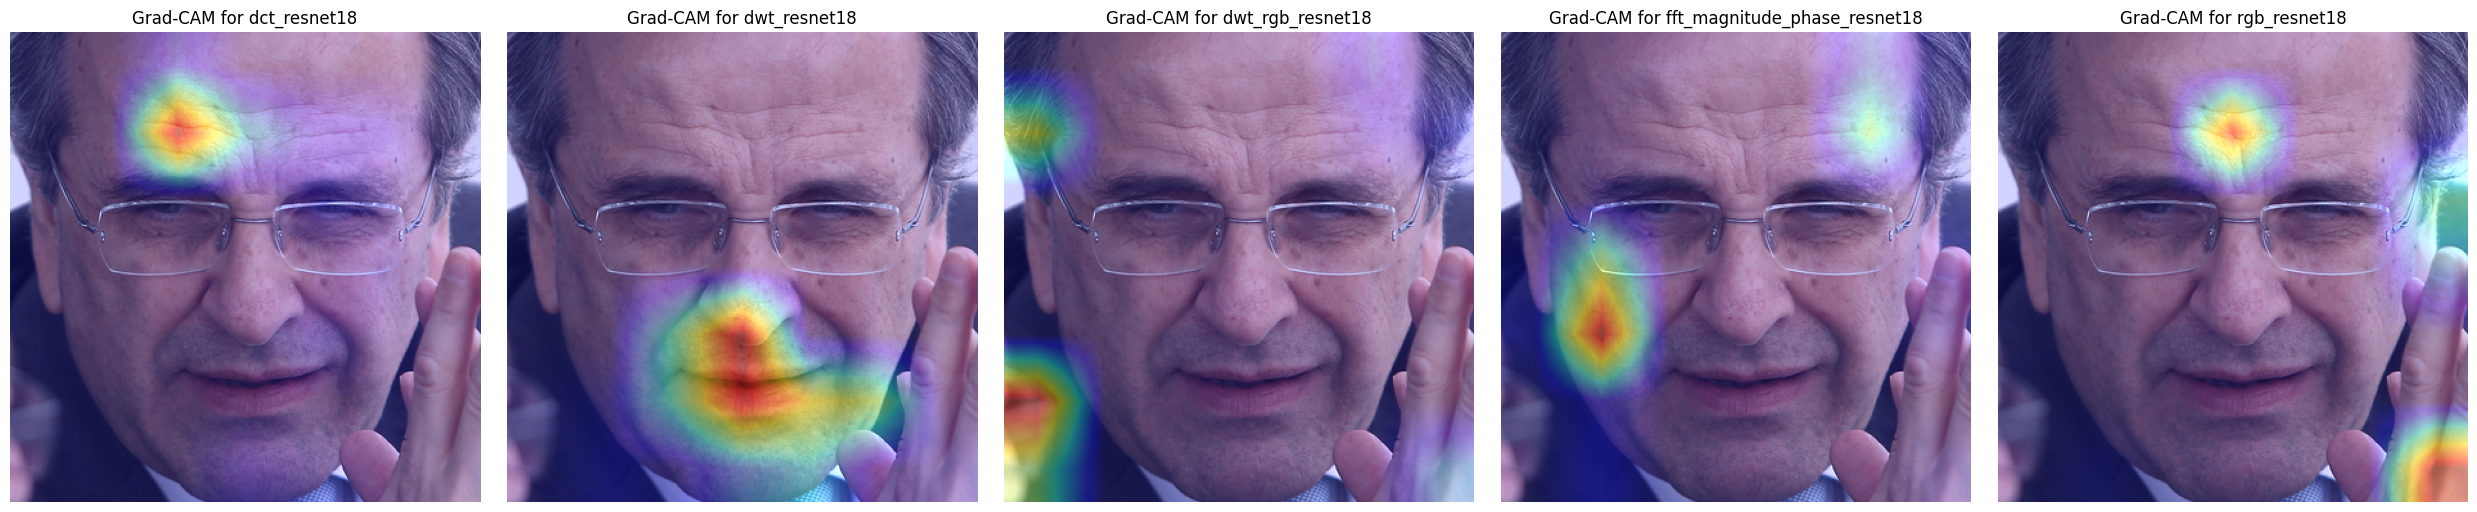

In [42]:
import os # Ensure os is imported for directory creation

target_layer_name = 'model.layer4' # This is a common structure for ResNet wrapped in a custom class.

results = []

for selected_model_id, model_instance in models.items():
    model_instance = model_instance.to(device)
    model_instance.eval()

    # Get the test transforms for the selected model
    test_transforms = transforms[selected_model_id]['test']

    # Apply transforms to the cropped face image
    input_tensor = test_transforms(cropped_face_pil_rgb).unsqueeze(0).to(device)

    grad_cam = GradCAM(model_instance, target_layer_name)

    # Compute heatmap
    heatmap = grad_cam(input_tensor)
    results.append((selected_model_id, cropped_face_pil_rgb, heatmap))

# Visualize all Grad-CAMs side-by-side
num_models = len(results)
fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5))

if num_models == 1:
    axes = [axes] # Make sure axes is iterable for a single plot

for i, (model_id, original_image, heatmap) in enumerate(results):
    visualize_cam(original_image, heatmap, ax=axes[i], title=f"Grad-CAM for {model_id}")

plt.tight_layout()

# Define output path and create directory if it doesn't exist
output_dir = os.path.join(proj_dir, 'analysis', 'gradcam')
output_filename = f'{img_id}.png'
output_path = os.path.join(output_dir, output_filename)

os.makedirs(output_dir, exist_ok=True)

# Save the figure before showing it
fig.savefig(output_path, bbox_inches='tight', dpi=300)
print(f"Image saved as '{output_path}'")

plt.show()
